# Nonlinearly-Observed LDS

## Some background
For notation, we write $\mathcal{S} \subset \mathbb{R}^{d_s}, \mathcal{O} \subset \mathbb{R}^{d_o}, \mathcal{U} \subset \mathbb{R}^{d_u}, \mathcal{Z} \subset \mathbb{R}^{d_l}$ to be the state, observation, control, and embedding vector spaces, respectively. In this notebook, we will experiment under the following model: 

We suppose that there is a ground truth linear dynamical system with states $x_t \in \mathcal{S}$, controls $u_t \in \mathcal{U}$, and dynamics
$$x_{t+1} = A x_t + B u_t$$
for some linear transformations $A : \mathcal{S} \rightarrow \mathcal{S}$ and $B: \mathcal{U} \rightarrow \mathcal{S}$. As usual, we require $\|A\|_{op} < 1$ for Lyapunov stability. We will be observing this LDS with a nonlinear (_and injective!_) observation function $g: \mathcal{S} \rightarrow \mathcal{O}$. The costs are the usual quadratic $\ell(x) = \|x\|^2$.

Of course, this induces (nonlinear) dynamics on the iterates $g(x_t)$ in $\mathcal{O}$, but we know that there is a ground truth LDS to be recovered. We seek lifting maps $f: \mathcal{O} \rightarrow \mathcal{Z}$ to recover the linear dynamics; morally, we want $f \circ g$ to be the identity. In fact, it can be a bit more general, see below.

#### <u>Proposition</u>: A lifting map $f$ yields a faithful, linearizing, and cost-preserving representation of the original dynamical system $(A, B)$ <u>if and only if</u> $f \circ g$ is a linear isometry over $range(A) \oplus range(B)$.

#### <u>Proof</u>: 
Check the overleaf for the proof, but it goes something like the following. Let $T: \mathcal{S} \rightarrow \mathcal{Z}$ denote $f \circ g$.

($\implies$) Suppose $f$ yields a faithful, linearizing, and cost-preserving representation. Then, $\ell(x) = \ell(Tx)$ for all reachable $x \in \mathcal{S}$ implies that $\|x\|^2 = \|Tx\|^2$, and so $T$ is an isometry where it matters. This also means that $T(0) = 0$. Next, since it's linearizing, there are some $\tilde{A}: \mathcal{Z} \rightarrow \mathcal{Z}$ and $\tilde{B}: \mathcal{U} \rightarrow \mathcal{Z}$ for which $$\tilde{A}Tx_t + \tilde{B}u_t = Tx_{t+1} = T(Ax_t + Bu_t)$$
Since this must hold for all states and controls, we find that $\tilde{A} T = TA$ and $\tilde{B} = TB$. Immediately, we see that $T$ must be linear over $range(A) \oplus range(B)$.

($\impliedby$) Suppose $f$ is a linear isometry over $range(A) \oplus range(B)$. Then, $\|x\|^2 = \|Tx\|^2$ for all reachable $x \in \mathcal{S}$ implies that $\ell(x) = \ell((f \circ g)x)$, and so $f$ preserves costs. Since $T$ is a linear isometry, then $T$ has trivial kernel and so is injective, meaning the representation is faithful. Lastly, we can confirm that the system is linearized with any dynamics $(\tilde{A}, \tilde{B})$ satisfying $T^{-1}\tilde{A}T = A$ and $\tilde{B} = TB$. If $d_s = d_l$ and we are lifting to the correct dimension, then $T$ is automatically invertible and these dynamics $(\tilde{A}, \tilde{B})$ are unique. $\blacksquare$

## Defining our tests
It seems that we get exactly what we want if and only if $f \circ g$ is a linear isometry over the reachable states. So, it makes sense to test if we can produce a linear isometry under more and more complex/interesting choices of $g$. All that really changes in the different experiments in this notebook is our selection of $g$, the dimensions $d_s, d_u, d_l$, and the system matrices $A, B$. So, we will write the code the rest below.

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import tqdm

from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS, Gym
from extravaganza.observables import Observable, TimeDelayedObservation, Trajectory
from extravaganza.sysid import Lifter
from extravaganza.utils import summarize_lds, sample, jkey, opnorm, SAMPLING_METHOD

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmp3a3vzsdz
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmp3a3vzsdz/_remote_module_non_scriptable.py


In [2]:
def run(observable, ds: int, du: int,
        T0: int, reset_every: int, sysid_args):
    """
    fn to gather data and train a sysid.
    """
    # make system
    done = False
    while not done:
        system = LDS(ds, du, 'none', 'quad', seed=SYSTEM_SEED)
        A, B = system.A, system.B
        done = all(jnp.linalg.eigvals(A) > 0.3) and all(jnp.linalg.svd(B)[1] > 0.3)
    print(summarize_lds(A, B))

    # make sysid
    sysid = Lifter(**sysid_args)

    # interaction loop
    control = jnp.zeros(du)
    max_sq_norm = 0.
    traj = Trajectory()
    for t in tqdm.trange(T0):
        if t % reset_every == 0: 
            system.reset()
            system.state = sample(jkey(), (ds,), sampling_method='ball')
            sysid.end_trajectory()
            traj = Trajectory()
        cost, state = system.interact(control)
        traj.add_state(cost, state)
        obs = observable(traj)
        control = sysid.explore(cost, obs)
        traj.add_control(control)
        max_sq_norm = max(max_sq_norm, jnp.linalg.norm(state) ** 2)
    sysid.end_exploration(wordy=True)
    return A, B, sysid, max_sq_norm

In [3]:
def generate(observable, A, B, sysid, max_sq_norm, sampling_method='ball', 
             N=1000, reset_every=10, hh=10, use_pbar=True):
    ds, du = B.shape
    do, dl = sysid.obs_dim, sysid.state_dim
    states = []
    controls = []
    observations = []
    embeddings = []
    cost, obs, u = 0., jnp.zeros(do), jnp.zeros(du)
    if use_pbar: pbar = tqdm.tqdm(total=N)
    while len(embeddings) < N:
        if len(embeddings) % reset_every == 0:
            traj = Trajectory()
            x = (max_sq_norm ** 0.5) * sample(jkey(), (ds,), sampling_method=sampling_method)
        
        x = A @ x + B @ u
        cost = jnp.linalg.norm(x) ** 2
        traj.add_state(cost, x)
        obs = observable(traj)
        emb = sysid.get_state(obs, cost)        
        u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
        traj.add_control(u)
        
        states.append(x)
        controls.append(u)
        observations.append(obs)
        embeddings.append(emb)
        if use_pbar: pbar.update(1)
    if use_pbar: pbar.close()
    states, controls, observations, embeddings = map(lambda arr: jnp.stack(arr, axis=0), (states, controls, observations, embeddings))
    states, controls, observations, embeddings = states.reshape(N, ds), controls.reshape(N, du), observations.reshape(N, do), embeddings.reshape(N, dl)
    return states, controls, observations, embeddings

In [4]:
def summarize(observable, A, B, sysid, max_sq_norm, sampling_method='ball', N=1000, reset_every=10, hh=10):
    """
    We know that if we have succeeded, our embedding composed with our observation function is a linear transformation of the original state.
    Below, we regress this transformation, C, and compute some errors with it.
    """
    Ahat, Bhat = sysid.A, sysid.B
    ds, du = B.shape
    assert du == sysid.control_dim, (du, sysid.control_dim)
    do, dl = sysid.obs_dim, sysid.state_dim, 
    
    states, _, _, embeddings = generate(observable, A, B, sysid, max_sq_norm, sampling_method, N, reset_every, hh)

    # -------- FORWARD DIRECTION, showing that T = f \circ g linearizes ------------------------
    print('forward direction:')
    C_forward = jnp.linalg.lstsq(states, embeddings, rcond=-1)[0].T
    print('\t||Ahat @ C - C @ A||^2: \t{}'.format(jnp.linalg.norm(Ahat @ C_forward - C_forward @ A) ** 2))
    print('\t||Bhat - C @ B||^2: \t\t{}'.format(jnp.linalg.norm(Bhat - C_forward @ B) ** 2))

#     residuals = (C_forward[None] @ states[:, :, None]).squeeze() - embeddings
#     residual_norms = jnp.linalg.norm(residuals, axis=-1) ** 2
#     state_norms = jnp.linalg.norm(embeddings, axis=-1) ** 2
#     print('\tAvg % error: \t\t\t{}%'.format(100 * jnp.mean(residual_norms / state_norms)))
#     plt.scatter(state_norms, residual_norms)
#     plt.show()

    # -------- REVERSE DIRECTION, showing that T^{-1} = (f \circ g)^{-1} linearizes -----------------------
    print('reverse direction:')
    C_reverse = jnp.linalg.lstsq(embeddings, states, rcond=-1)[0].T
    print('\t||A @ C - C @ Ahat||^2: \t{}'.format(jnp.linalg.norm(A @ C_reverse - C_reverse @ Ahat) ** 2))
    print('\t||B - C @ Bhat||^2: \t\t{}'.format(jnp.linalg.norm(B - C_reverse @ Bhat) ** 2))

#     residuals = (C_reverse[None] @ embeddings[:, :, None]).squeeze() - states
#     residual_norms = jnp.linalg.norm(residuals, axis=-1) ** 2
#     state_norms = jnp.linalg.norm(states, axis=-1) ** 2
#     print('\tAvg % error: \t\t\t{}%'.format(100 * jnp.mean(residual_norms / state_norms)))
#     plt.scatter(state_norms, residual_norms)
#     plt.show()

    print()
    print('injectivity: \t||C_reverse @ C_forward - I_ds||^2 / ds^2 = {}'.format(jnp.linalg.norm(C_reverse @ C_forward - jnp.eye(ds)) ** 2 / ds ** 2))
    print('surjectivity: \t||C_forward @ C_reverse - I_dl||^2 / dl^2 = {}'.format(jnp.linalg.norm(C_forward @ C_reverse - jnp.eye(dl)) ** 2 / dl ** 2))
    
    print()
    print('singular values of C_forward: \t{}'.format(jnp.linalg.svd(C_forward)[1]))
    print('singular values of C_reverse: \t{}'.format(jnp.linalg.svd(C_reverse)[1]))
    if hasattr(sysid, 'fmean'): print('sqrt(fmean): \t\t{}'.format(sysid.fmean ** 0.5))
    pass

In [5]:
def print_prediction(observable, A, B, sysid, max_sq_norm, k=1, sampling_method='ball', hh=10):
    """
    See some prediction instances
    Here, 'original' means (f \circ g)(x_t), 'gt' means (f \circ g)(x_{t+k}), and 
        'pred' is the predicted embedding at t+k using linear dynamics given by (Ahat, Bhat).
    All norms are in the embedding space
    """
    Ahat, Bhat = sysid.A, sysid.B
    
    traj = Trajectory()
    x = (max_sq_norm ** 0.5) * sample(jkey(), (ds,), sampling_method=sampling_method)
    for _ in range(hh):
        u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
        traj.add_control(u)
        x = A @ x + B @ u
        traj.add_state(jnp.linalg.norm(x) ** 2, x)
    
    s = sysid.get_state(observable(traj), jnp.linalg.norm(x) ** 2)
    original = s.copy()
    for _ in range(k):
        u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
        traj.add_control(u)
        x = A @ x + B @ u
        traj.add_state(jnp.linalg.norm(x) ** 2, x)
        s = Ahat @ s + Bhat @ u
    gt = sysid.get_state(observable(traj), jnp.linalg.norm(x) ** 2)
    pred = s.copy()
    print(f'||gt - original||={jnp.linalg.norm(gt - original)}\t||pred - original||={jnp.linalg.norm(pred - original)}\t||gt - pred||={jnp.linalg.norm(gt - pred)}')
    pass

In [6]:
def plot_1d(observable, A, B, sysid, max_sq_norm, sampling_method='ball', N=2000, reset_every=10, hh=1):
    assert A.shape[0] == 1 and sysid.state_dim == 1

    xs, _, os, zs = generate(observable, A, B, sysid, max_sq_norm, sampling_method, N, reset_every, hh)
    idxs = jnp.argsort(xs.squeeze())
    xs, os, zs = xs[idxs].reshape(-1), os[idxs].reshape(*os.shape), zs[idxs].reshape(-1)
#     zs = zs * (sysid.fmean ** 0.5)

    do = os.shape[1]
    fig, ax = plt.subplots(nrows=do, ncols=2, figsize=(12, do * 5))
    ax = ax.reshape(do, 2)
    _xs, _zs = xs, zs
    for i in range(do):
        _os = os[:, i]
        ax[i, 0].plot(_xs, _os, color='r', label='obs(x)')
        ax[i, 0].scatter(_xs, _zs, s=4, color='b', label='(embedding \circ obs)(x)')
        ax[i, 1].plot(_os, _xs, color='c', label='x(obs)')
        ax[i, 1].scatter(_os, _zs, s=4, color='purple', label='embedding(obs)')

        ax[i, 0].set_title('state space')
        ax[i, 0].set_xlabel('state')
        ax[i, 1].set_xlabel('observation_{}'.format(i))
        ax[i, 1].set_title('{}th coord of observation space'.format(i))
        ax[i, 0].legend(); ax[i, 1].legend()
    plt.show()
    pass

In [7]:
def plot_2d(observable, A, B, sysid, max_sq_norm, sampling_method='ball', N=2000, reset_every=10, hh=10):
    assert A.shape[0] == 2
    assert isinstance(observable, TimeDelayedObservation) and observable.obs_dim == sysid.obs_dim and sysid.obs_dim == hh * (B.shape[1] + 1)

    xs, _, os, zs = generate(observable, A, B, sysid, max_sq_norm, sampling_method, N, reset_every, hh)
    #     zs = zs * (sysid.fmean ** 0.5)

    C_reverse = jnp.linalg.lstsq(zs, xs, rcond=-1)[0].T

    do = os.shape[1]
    _xs, _zs = xs, (C_reverse @ zs.reshape(-1, sysid.state_dim, 1)).reshape(-1, 2)
    _os = os[:, -1]
    
    nrows = 3
    fig = plt.figure(figsize=(12, nrows * 5))
    ax = []
    
    ax.append(fig.add_subplot(nrows, 2, len(ax) + 1, projection='3d'))
    surf = ax[-1].plot_trisurf(_xs[:, 0], _xs[:, 1], _os, cmap=cm.coolwarm)
#     fig.colorbar(surf, shrink=0.5, aspect=5)
    ax[-1].set_title('obs(state)')
    ax[-1].set_xlabel('state_0')
    ax[-1].set_ylabel('state_1')
    ax[-1].set_zlabel('cost')
    
    ax.append(fig.add_subplot(nrows, 2, len(ax) + 1, projection='3d'))
    surf = ax[-1].plot_trisurf(_xs[:, 1], -_xs[:, 0], _os, cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax[-1].set_title('obs(state)')
    ax[-1].set_xlabel('state_1')
    ax[-1].set_ylabel('-state_0')
    ax[-1].set_zlabel('cost')
    
    ax.append(fig.add_subplot(nrows, 2, len(ax) + 1, projection='3d'))
    surf = ax[-1].plot_trisurf(_xs[:, 0], _xs[:, 1], _zs[:, 0], cmap=cm.coolwarm)
    ax[-1].set_title('embedding(obs(state))_0')
    ax[-1].set_xlabel('state_0')
    ax[-1].set_ylabel('state_1')
    
    ax.append(fig.add_subplot(nrows, 2, len(ax) + 1, projection='3d'))
    surf = ax[-1].plot_trisurf(_xs[:, 1], -_xs[:, 0], _zs[:, 0], cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax[-1].set_title('embedding(obs(state))_0')
    ax[-1].set_xlabel('state_1')
    ax[-1].set_ylabel('-state_0')
    
    ax.append(fig.add_subplot(nrows, 2, len(ax) + 1, projection='3d'))
    surf = ax[-1].plot_trisurf(_xs[:, 0], _xs[:, 1], _zs[:, 1], cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax[-1].set_title('embedding(obs(state))_1')
    ax[-1].set_xlabel('state_0')
    ax[-1].set_ylabel('state_1')

    ax.append(fig.add_subplot(nrows, 2, len(ax) + 1, projection='3d'))
    surf = ax[-1].plot_trisurf(_xs[:, 1], -_xs[:, 0], _zs[:, 1], cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax[-1].set_title('embedding(obs(state))_1')
    ax[-1].set_xlabel('state_1')
    ax[-1].set_ylabel('-state_0')
    plt.show()
    pass

# (1) Identity observation (as a sanity check)
We consider the map $g$ sending $x \mapsto x$. The dynamics are linear w.r.t. these observations, and so our neural network really only needs to learn the identity map (or any linear map). Let's see how it does!

In [8]:
# # dimensions
# ds, du, dl = 4, 4, 4

# # define observation fn
# g = lambda x: x
# observable = lambda traj: g(traj.x[-1])
# do = ds

# # send it
# T0 = 2000
# reset_every = 20
# exploration_args = {'scales': 0.5, 'avg_len': 5}
# sysid_args = {
#     'obs_dim': do,
#     'control_dim': du,
#     'state_dim': dl,

#     'exploration_args': {'random 1.0': exploration_args,
# #                          'impulse 0.25': exploration_args,
#                         },

#     'method': 'nn',
#     'AB_method': 'learned',

#     'sigma': 0.01,
#     'deterministic_encoder': False,
#     'depth': 6,
#     'num_iters': 24000,
#     'batch_size': 128,
#     'lifter_lr': 0.001,

#     'seed': SYSID_SEED,
# }
# A, B, sysid, max_sq_norm = run(observable, ds, du, T0, reset_every, sysid_args)

In [9]:
# # check things
# summarize(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every)
# print('\npredictions:')
# for _ in range(5):
#     print_prediction(observable, A, B, sysid, max_sq_norm, sampling_method='ball', k=1)

# (2) Nonlinear injective observation with $d_s=d_o=d_l=1$
Here, we play with systems with 1-dimensional states for plotting and interpretation convenience. In particular, $A$ is a scalar, $B$ is a $1 \times d_u$ column vector, and we use the observation function $g: \mathbb{R} \rightarrow \mathbb{R}$ given by
$$g(x) := sign(x) \cdot \sqrt{|x|}$$
As we see, this is nonlinear (looks sorta sigmoidal), but it is invertible. Let's see what happens!

In [18]:
# dimensions
ds, du, dl = 1, 1, 1

# define observation fn
g = lambda t: jnp.sign(t) * (jnp.abs(t) ** 0.5)
observable = lambda traj: g(traj.x[-1])
do = ds

# send it
T0 = 5000
reset_every = 20
exploration_args = {'scales': 0.5, 'avg_len': 5}
sysid_args = {
    'obs_dim': do,
    'control_dim': du,
    'state_dim': dl,

    'exploration_args': {'random 1.0': exploration_args,
#                          'impulse 0.25': exploration_args,
                        },

    'method': 'nn',
    'AB_method': 'regression',

    'sigma': 0.1,
    'deterministic_encoder': False,
    'depth': 6,
    'num_iters': 24000,
    'batch_size': 128,
    'lifter_lr': 0.001,

    'seed': SYSID_SEED,
}
A, B, sysid, max_sq_norm = run(observable, ds, du, T0, reset_every, sysid_args)

INFO: (EXPLORER) generating exploration control sequences using ['random'] w.p. [1.]


||A||_op = 0.42927315831184387
||B||_F = 0.7578225135803223
||A-BK||_op = 0.2606929540634155
eig(A) = [0.42927316]
svd(B) = [0.7578225]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2102.59it/s]
INFO: (LIFTER): we are imposing simplification as a hard constraint on the latent space via isometric NN
INFO: (LIFTER): we will be linearizing in dimension 3 and linearly project down to dimension 1
INFO: (LIFTER): using "regression" method to get the AB matrices during each training step
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4429.47it/s]
INFO: (LIFTER): ending sysid phase at step 5000
INFO: (LIFTER): NOTE THAT WE ARE USING FMEAN TO RESCALE EMBEDDINGS DURING INFERENCE (so outputs of `get_state()` will have their true norms instead of their normalized ones)!!!
INFO: training!
INFO: mean loss for iters -2400 - 0:
INFO: 		dot: 	0.5941668748855591
INFO: 		l2 linearization 0: 	0.3862011432647705
INFO: 		proj_error: 	0.0026040696538984776
INFO: 	

regression (ret) :
||A||_op = 0.6819308400154114
||B||_F = 0.004016703926026821
||A-BK||_op = 0.6819102764129639
eig(A) = [0.68193084]
svd(B) = [0.0040167]

moments :
||A||_op = 0.5993591547012329
||B||_F = 0.0010056182509288192
||A-BK||_op = 0.5993582010269165
eig(A) = [0.59935915]
svd(B) = [0.00100562]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1703.44it/s]


forward direction:
	||Ahat @ C - C @ A||^2: 	0.00013139336078893393
	||Bhat - C @ B||^2: 		0.0009220056817866862
reverse direction:
	||A @ C - C @ Ahat||^2: 	0.0018506052438169718
	||B - C @ Bhat||^2: 		0.5732588768005371

injectivity: 	||C_reverse @ C_forward - I_ds||^2 / ds^2 = 0.984610378742218
surjectivity: 	||C_forward @ C_reverse - I_dl||^2 / dl^2 = 0.984610378742218

singular values of C_forward: 	[0.04536847]
singular values of C_reverse: 	[0.1702646]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1787.53it/s]


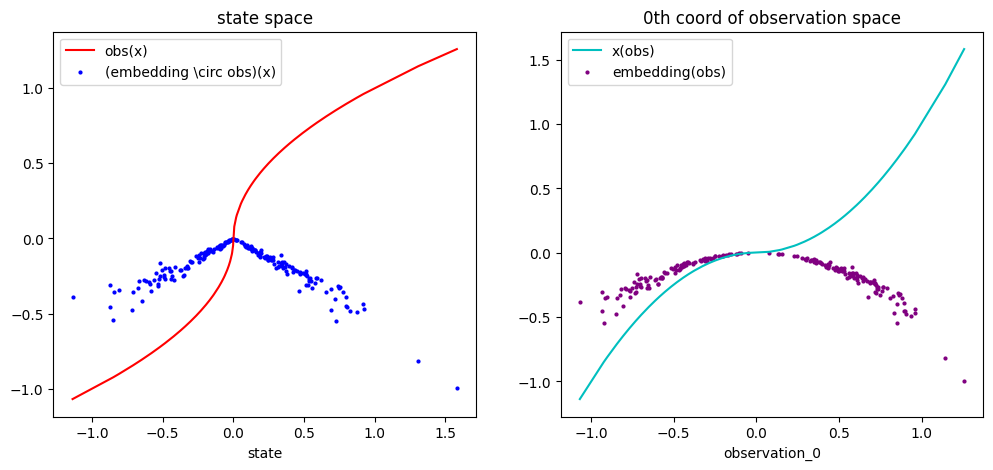

In [19]:
# check linearization and plot some stuff
summarize(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every)
plot_1d(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every, N=200)

# (3) Nonlinear 2-to-1 observation with $d_s=d_l=1$
Again, we use 1-dimensional stuff here; we will look into how this scales as we increase dimension later. Now, our observation function $g: \mathbb{R} \rightarrow \mathbb{R}$ is given by
$$g(x) := x^2$$
This is nonlinear and **not injective**. Two distinct states ($x$ and $-x$) will produce the same observations, and yet they will evolve differently. For example, if we knew $g(x_{t})$, $u_t$, and $g(x_{t-1})$, then we can differentiate between the two states that produce the same observation. We will investigate the efficacy of such ***time-delayed observations*** below.

As a clarifying example, suppose $d_u=1$ and $A=B=1$ (i know its only semistable, but simple constants). Then, while the map $x \mapsto x^2$ is not injective, the map $x_{t} \mapsto (x_{t-1}^2, u_t, x_t^2)$ is. To see this, let us construct a left inverse. Note that $$x_t = x_{t-1} + u_t \implies x_t^2 = x_{t-1}^2 + u_t^2 + 2u_tx_{t-1} \implies x_{t-1} = \frac{x_t^2 - x_{t-1}^2}{2u_t} - \frac{u_t}{2}$$
Therefore, using only the variables $(x_{t-1}^2, u_t, x_t^2)$ we may write
$$x_t = \frac{x_t^2 - x_{t-1}^2}{2u_t} + \frac{u_t}{2}$$
This time-delayed observation with $d_o = 3$ is enough to faithfully represent the system, which realizes the upper bound $d_o \leq 3$ given by the Takens embedding (more on this later). (In fact, in this case we can do it with only $d_o=2$ using the variables $(x_t^2 - x_{t-1}^2, u_t) = (g(x_t) - g(x_{t-1}), u_t)$, though this only works here because of the properties of quadratics).

We attempt to have our method learn a linearization to this representation below.

In [12]:
# # dimensions
# ds, du, dl = 1, 1, 1

# # define observation fn
# hh = 2
# observable = TimeDelayedObservation(hh=hh, control_dim=du, state_dim=ds,
#                                     use_states=False, use_controls=True, 
#                                     use_costs=True, use_cost_diffs=False,
#                                     use_time=False)
# do = observable.obs_dim

# # send it
# T0 = 5000
# reset_every = 20
# exploration_args = {'scales': 1., 'avg_len': 4}
# sysid_args = {
#     'obs_dim': do,
#     'control_dim': du,
#     'state_dim': dl,

#     'exploration_args': {'random 1.0': exploration_args,
# #                          'impulse 0.25': exploration_args,
#                         },

#     'method': 'nn',
#     'AB_method': 'learned',
    
#     'sigma': 0.01,
#     'deterministic_encoder': False,

#     'depth': 6,
#     'num_iters': 32000,
#     'batch_size': 128,
#     'lifter_lr': 0.001,
#     'hh': hh,

#     'seed': SYSID_SEED,
# }
# A, B, sysid, max_sq_norm = run(observable, ds, du, T0, reset_every, sysid_args)

In [13]:
# # you know the drill
# summarize(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every, hh=hh)
# plot_1d(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every, N=2000, hh=hh)

# (4) Nonlinear many-to-1 observation with $d_s=d_l=n$
We next seek to understand how the proposed method of time-delay embeddings scales with dimension. Our observation function $g: \mathbb{R}^n \rightarrow \mathbb{R}$ is now 
$$g(x) := \|x\|^2$$
This is nonlinear and **super-duper not injective**. Each sphere in $\mathbb{R}^n$ gets condensed into a single observation value. Can we hope to recover the initial states? We appeal to the following theorem (see https://en.wikipedia.org/wiki/Takens%27s_theorem):
#### <u>Takens' Theorem (informal)</u>:  Given a dynamical system on $X = \mathbb{R}^n$ with smooth and determinstic dynamics and a smooth observation function $g: X \rightarrow \mathbb{R}$ that is coupled to all dimensions of $X$, the following map is injective:
$$x_t \mapsto (g(x_{t}), g(x_{t+1}), ..., g(x_{t+2n}))$$

We saw a special case of this before when $n=1$. In general, we expect that our time-delayed observation should contain at least $2n + 1$ measurements to guarantee injectivity. We try this below.

<!-- Just to prove it, the general case for a 1-dimensional LDS would be 
$$x_{t} = Ax_{t-1} + Bu_t \implies x_t^2 = A^2x_{t-1}^2 + B^2u_t^2 + 2ABx_{t-1}u_t \implies x_{t-1} = \frac{x_t^2 - A^2x_{t-1}^2}{2ABu_t} - \frac{Bu_t}{2A} \implies x_t = \frac{x_t^2 - A^2x_{t-1}^2}{2Bu_t} + \frac{Bu_t}{2}$$ -->

In [14]:
# # dimensions
# n = 6
# ds, du, dl = n, n, n

# # define observation fn
# hh = 2 * ds + 1
# observable = TimeDelayedObservation(hh=hh, control_dim=du, state_dim=ds,
#                                     use_states=False, use_controls=True, 
#                                     use_costs=True, use_cost_diffs=False,
#                                     use_time=False)
# do = observable.obs_dim

# # send it
# T0 = 10000
# reset_every = 200
# exploration_args = {'scales': 1., 'avg_len': 4}
# sysid_args = {
#     'obs_dim': do,
#     'control_dim': du,
#     'state_dim': dl,

#     'exploration_args': {'random 1.0': exploration_args,
# #                          'impulse 0.25': exploration_args,
#                         },

#     'method': 'nn',
#     'AB_method': 'learned',
    
#     'sigma': 0,
#     'deterministic_encoder': False,

#     'depth': 8,
#     'num_iters': 48000,
#     'batch_size': 128,
#     'lifter_lr': 0.001,
#     'hh': n,

#     'seed': SYSID_SEED,
# }
# A, B, sysid, max_sq_norm = run(observable, ds, du, T0, reset_every, sysid_args)

In [15]:
# # the same
# summarize(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every, hh=hh)
# if n == 2: plot_2d(observable, A, B, sysid, max_sq_norm, sampling_method='ball', N=2000, reset_every=reset_every, hh=hh)

In [16]:
# import jax.numpy as jnp
# import numpy as np
# from extravaganza.utils import sample, jkey, set_seed
# from extravaganza.sysid import Lifter
# from extravaganza.observables import TimeDelayedObservation, Trajectory
# # set_seed(4000)

# ds, du = 5, 3
# hh = 3
# A, B = sample(jkey(), (ds, ds)), sample(jkey(), (ds, du))
# observable = TimeDelayedObservation(hh, control_dim=du,
#                                     use_controls=True, use_costs=True, 
#                                     use_states=False, use_cost_diffs=False, use_time=False)
# do = observable.obs_dim

# N, reset_every = 5000, 100
# x_scale, u_scale = 1., 1.
# exploration_args = {'scales': u_scale, 'avg_len': 4}
# sysid_args = {
#     'obs_dim': ds,
#     'control_dim': du,
#     'state_dim': ds,
#     'exploration_args': {'random 1.0': exploration_args,
# #                          'impulse 0.25': exploration_args,
#                         },
#     'method': 'identity'}
# sysid = Lifter(**sysid_args)

# observations = []
# pbar = tqdm.tqdm(total=N)

# while len(observations) < N:
#     if len(observations) % reset_every == 0:
#         sysid.end_trajectory()
#         traj = Trajectory()
#         x = x_scale * sample(jkey(), (ds,), sampling_method='ball')
#         cost = jnp.linalg.norm(x) ** 2
            
#     traj.add_state(cost, x)
#     obs = observable(traj)
#     observations.append(obs)
#     u = sysid.explore(cost, x)
#     traj.add_control(u)
#     x = A @ x + B @ u
#     cost = jnp.linalg.norm(x) ** 2
    
#     pbar.update(1)
# use_pbar: pbar.close()
    
# states, controls, costs = sysid.concatenate_trajectories()
# observations = jnp.stack(observations, axis=0)

# # find the index of the last datapoint in each trajectory. we will ignore loss terms referencing x_t and x_{t+1} for all t in ignore_idxs,
# # since a reset happened between those two points
# traj_lens = [len(traj) for traj in sysid.trajs]
# ignore_idxs = np.cumsum(traj_lens) - 1  # -1 to capture last idxs of old trajs, not first idxs of new trajs
# mask = np.ones(states.shape[0], dtype=bool)
# for idx in ignore_idxs: mask[max(0, idx - hh + 1): idx + hh + 1] = False
# mask[:hh] = False
# mask = mask[:-1]

# pinv = jnp.linalg.pinv(B)
# assert jnp.allclose(pinv @ B, jnp.eye(B.shape[1]), rtol=1e-6, atol=1e-6), (pinv @ B)

# # make sure everything is in order
# args = {'atol': 1e-3, 'rtol': 1e-3}
# assert jnp.allclose(jnp.linalg.norm(states[:-1], axis=-1)[mask] ** 2, observations[:-1, -1][mask], **args)
# xhats = (A @ states[:-1, :, None] + B @ controls[:-1, :, None]).squeeze(-1)
# assert jnp.allclose(xhats[mask], states[1:][mask], **args)
# uhats = (pinv @ (states[1:][:, :, None] - (A @ states[:-1][:, :, None]))).squeeze(-1) 
# assert jnp.allclose(uhats[mask], controls[:-1][mask], **args)
# print('everything is in order!')

# diffs = (states[1:] - states[:-1])[mask]
# diffs = diffs / jnp.linalg.norm(diffs, axis=-1)[:, None]
# _us = (B @ controls[:-1, :, None]).squeeze(-1)[mask]
# RHS = (sysid.explorer.exploration_scales[0].item() * jnp.linalg.norm(B, ord='fro')) ** 2                    
# LHS = (diffs * _us).sum(axis=-1)
# plt.scatter(range(mask.sum()), LHS)
# LHS.mean() / (jnp.linalg.norm(B, ord='fro') ** 2)

In [17]:
# import jax.numpy as jnp
# import numpy as np
# from extravaganza.utils import sample, jkey, set_seed
# from extravaganza.sysid import Lifter
# from extravaganza.observables import TimeDelayedObservation, Trajectory
# from extravaganza.observables import FullObservation
# # set_seed(5)

# ds, du = 5, 3
# A, B = sample(jkey(), (ds, ds)), sample(jkey(), (ds, du))

# T0, reset_every = 10000, 100
# observable = FullObservation(ds)
# x_scale, u_scale = 1., 0.2
# exploration_args = {'scales': u_scale, 'avg_len': 4}
# sysid_args = {
#     'obs_dim': ds,
#     'control_dim': du,
#     'state_dim': ds,
#     'exploration_args': {'random 1.0': exploration_args,
# #                          'impulse 0.25': exploration_args,
#                         },
#     'method': 'identity'}
# # xs, us, os, zs = generate(observable, A, B, sysid, max_sq_norm=1., sampling_method='normal', hh=3)

# A, B, sysid, max_sq_norm = run(observable, ds, du, T0, reset_every, sysid_args)
# xs, us, zs = sysid.concatenate_trajectories()
# traj_lens = [len(traj) for traj in sysid.trajs]
# ignore_idxs = np.cumsum(traj_lens) - 1  # -1 to capture last idxs of old trajs, not first idxs of new trajs
# mask = np.ones(xs.shape[0], dtype=bool)
# for idx in ignore_idxs: mask[max(0, idx - sysid.hh + 1): idx + sysid.hh + 1] = False  # anything within +/- hh of a reset must go
# mask[:sysid.hh] = False  # the first hh must go
# mask = mask[:-1]
        
# # make sure everything is in order
# args = {'atol': 1e-3, 'rtol': 1e-3}
# pinv = jnp.linalg.pinv(B)
# assert jnp.allclose(pinv @ B, jnp.eye(B.shape[1]), **args), (pinv @ B)
# # assert jnp.allclose(jnp.linalg.norm(xs[:-1], axis=-1)[mask] ** 2, os[:-1, -1][mask], **args)
# xhats = (A @ xs[:-1, :, None] + B @ us[:-1, :, None]).squeeze(-1)
# assert jnp.allclose(xhats[mask], xs[1:][mask], **args)
# uhats = (pinv @ (xs[1:][:, :, None] - (A @ xs[:-1][:, :, None]))).squeeze(-1) 
# assert jnp.allclose(uhats[mask], us[:-1][mask], **args)
# print('everything is in order!')

# # diffs = (xs[1:] - xs[:-1])[mask]
# # # diffs = diffs / jnp.linalg.norm(diffs, axis=-1)[:, None]
# # _us = (B @ us[:-1, :, None]).squeeze(-1)[mask]
# # RHS = (sysid.explorer.exploration_scales[0].item() * jnp.linalg.norm(B, ord='fro')) ** 2                    
# # LHS = (diffs * _us).sum(axis=-1)
# # plt.scatter(range(mask.sum()), LHS)
# # LHS.mean(), RHS

# diffs = (xs[1:] - xs[:-1])[mask]
# diffs = (B.T @ diffs[:, :, None]).squeeze(-1)
# RHS = (sysid.explorer.exploration_scales[0].item() * jnp.linalg.norm(B, ord='fro')) ** 2                    
# LHS = (diffs * us[:-1][mask]).sum(axis=-1)
# plt.scatter(range(mask.sum()), LHS)
# LHS.mean(), RHS